In [ ]:
# Mount Google Drive (optional, for saving models)
from google.colab import drive
drive.mount('/content/drive')

# Install Kaggle API and download dataset
!pip install -q kaggle

# Upload your kaggle.json (run this and upload manually)
from google.colab import files
files.upload()  # upload kaggle.json

# Set up Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation --force


Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
100% 711M/714M [00:02<00:00, 255MB/s]
100% 714M/714M [00:02<00:00, 305MB/s]


In [ ]:
!unzip -o lgg-mri-segmentation.zip -d lgg_dataset/kaggle_3m/

Streaming output truncated to the last 5000 lines.
  inflating: lgg_dataset/kaggle_3m/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg_dataset/kaggle_3m/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg_dataset/kaggle_3m/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg_dataset/kaggle_3m/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg_dataset/kaggle_3m/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg_dataset/kaggle_3m/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg_dataset/kaggle_3m/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg_dataset/kaggle_3m/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19

In [ ]:
from glob import glob

# Correct deep path to where .tif images and masks exist
all_files = glob("lgg_dataset/kaggle_3m/lgg-mri-segmentation/kaggle_3m/*/*.tif")

# Separate images from masks
image_paths = sorted([f for f in all_files if not f.endswith("_mask.tif")])
mask_paths = sorted([f for f in all_files if f.endswith("_mask.tif")])

print("Images:", len(image_paths), "Masks:", len(mask_paths))

Images: 3929 Masks: 3929


In [ ]:
import os
from glob import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

IMG_SIZE = 128

# Get image and mask paths
image_paths = sorted(glob("lgg_dataset/kaggle_3m/lgg-mri-segmentation/kaggle_3m/*/*.tif"))
mask_paths = [p for p in image_paths if '_mask' in p]
image_paths = [p for p in image_paths if '_mask' not in p]

# Preprocess function
def preprocess(path, is_mask=False):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE if is_mask else cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype('float32') / 255.0
    if is_mask:
        img = np.expand_dims(img, axis=-1)
    return img

# Load and preprocess images and masks
images = np.array([preprocess(p) for p in image_paths])
masks = np.array([preprocess(p, is_mask=True) for p in mask_paths])

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    return Model(inputs, outputs, name="U-Net")


In [ ]:
# Callbacks
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "unet_best.h5", save_best_only=True, monitor='val_loss'
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=2, restore_best_weights=True, monitor='val_loss'
)


model = build_unet((IMG_SIZE, IMG_SIZE, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=3,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/3
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.9697 - loss: 0.1414 

197/197 ━━━━━━━━━━━━━━━━━━━━ 7423s 38s/step - accuracy: 0.9698 - loss: 0.1411 - val_accuracy: 0.9890 - val_loss: 0.0680
Epoch 2/3
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.9904 - loss: 0.0371 

197/197 ━━━━━━━━━━━━━━━━━━━━ 7366s 37s/step - accuracy: 0.9904 - loss: 0.0370 - val_accuracy: 0.9892 - val_loss: 0.0483
Epoch 3/3
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.9910 - loss: 0.0309 

197/197 ━━━━━━━━━━━━━━━━━━━━ 7320s 37s/step - accuracy: 0.9910 - loss: 0.0309 - val_accuracy: 0.9900 - val_loss: 0.0388


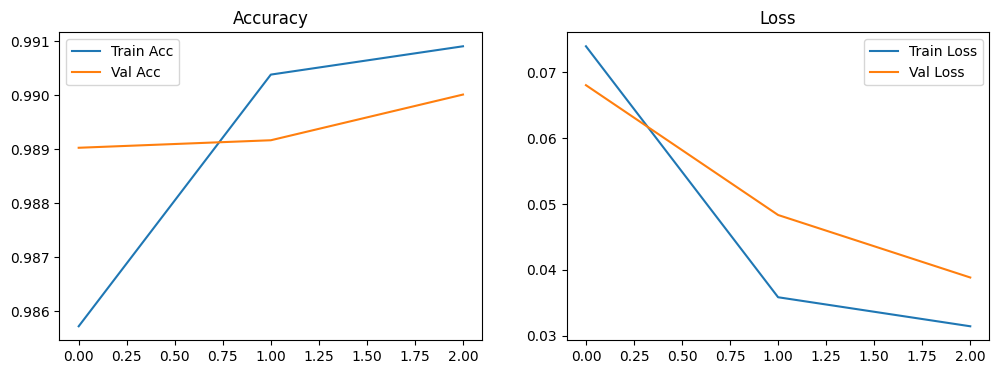

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


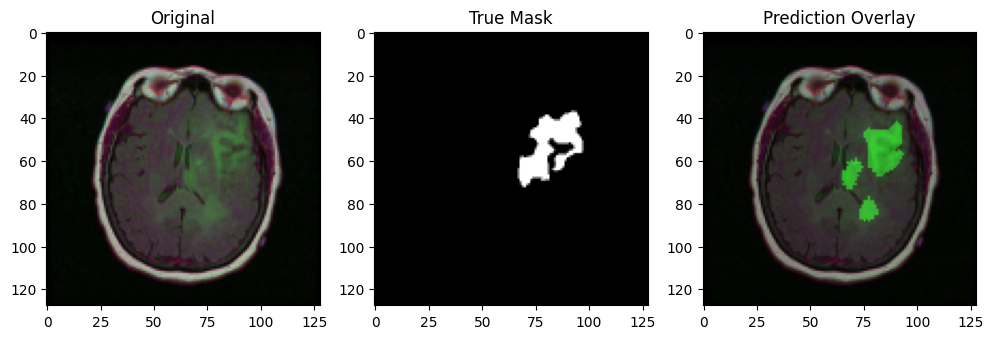

In [ ]:
def visualize_prediction(index):
    image = X_val[index]
    mask = y_val[index]
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0] > 0.5

    color_mask = np.zeros_like(image)
    color_mask[..., 1] = pred_mask[..., 0] * 255  # Green channel

    blended = (image * 255).astype('uint8')
    blended = cv2.addWeighted(blended, 0.8, color_mask.astype('uint8'), 0.4, 0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(image); plt.title('Original')
    plt.subplot(1,3,2); plt.imshow(mask[...,0], cmap='gray'); plt.title('True Mask')
    plt.subplot(1,3,3); plt.imshow(blended); plt.title('Prediction Overlay')
    plt.show()

visualize_prediction(3)


In [ ]:
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f"Test Accuracy: {test_acc:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 482s 19s/step - accuracy: 0.9899 - loss: 0.0393
Test Accuracy: 0.9900


In [ ]:
model.save('seg_unet_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('seg_unet_model.h5')

In [ ]:
import os
print('seg_unet_model.h5' in os.listdir())


True


In [ ]:
print(os.getcwd())

/content


In [ ]:
print(model.input_shape)

(None, 128, 128, 3)
